# DS CA7

Written by Parsa Ahmadi 810101609, Mahdi Naeini 810101536 and Babak Hosseini Mohtasham 810101408

# Imports

In [430]:
from wordcloud import WordCloud, STOPWORDS
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation,LabelSpreading
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import ttest_ind
from scipy import stats
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
import xgboost as xgb
from tqdm import tqdm
import plotly.graph_objects as go
random_state=42

# EDA

In [431]:
train_validation=pd.read_json('train_imdb.jsonl',lines=True)
aug=pd.read_json('aug_imdb_unlabeled.jsonl',lines=True)
test=pd.read_json('test_imdb.jsonl',lines=True)

In [432]:
train,validation=train_test_split(train_validation,train_size=0.8,random_state=random_state)

In [433]:
train_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.7+ KB


In [434]:
train_validation.describe()

,label
count,150.000000
mean,0.553333
std,0.498813
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [435]:
aug.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1014 entries, 0 to 1013
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1014 non-null   object
 1   embedding  1014 non-null   object
dtypes: object(2)
memory usage: 23.8+ KB


In [436]:
aug.describe()

,text,embedding
count,1014,1014
unique,1014,1014
top,there is no relation at all between fortier an...,"[-0.09757755700000001, -0.1536363065, 0.311417..."
freq,1,1


In [437]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       150 non-null    object
 1   label      150 non-null    int64 
 2   embedding  150 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.7+ KB


In [438]:
test.describe()

,label
count,150.000000
mean,0.480000
std,0.501274
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [439]:
train_validation_aug=pd.concat([train_validation,aug],ignore_index=True)
train_validation_aug['length']=train_validation_aug['text'].str.len()
train_validation_aug['word count']=train_validation_aug['text'].apply(lambda x: len(x.split()))
train_validation_aug['mean word length']=train_validation_aug['text'].apply(lambda x: np.mean([len(c) for c in x.split()]))
train_validation_aug.describe()

,label,length,word count,mean word length
count,150.000000,1164.000000,1164.000000,1164.000000
mean,0.553333,529.162371,94.008591,4.641433
std,0.498813,162.187296,28.075992,0.397687
min,0.000000,70.000000,12.000000,3.432836
25%,0.000000,392.000000,72.000000,4.368581
50%,1.000000,580.000000,103.000000,4.622344
75%,1.000000,662.000000,119.000000,4.889323
max,1.000000,891.000000,128.000000,6.333333


In [440]:
pd.concat([train_validation_aug[train_validation_aug['label']==0].describe(),
    train_validation_aug[train_validation_aug['label']==1].describe()],axis=1,names=['a','b'])

,label,length,word count,mean word length,label,length,word count,mean word length
count,67.0,67.000000,67.00000,67.000000,83.0,83.000000,83.000000,83.000000
mean,0.0,525.358209,92.80597,4.678376,1.0,486.409639,87.301205,4.576178
std,0.0,171.602492,30.42489,0.358783,0.0,165.553988,28.719304,0.376368
min,0.0,98.000000,18.00000,4.000000,1.0,165.000000,30.000000,3.887850
25%,0.0,357.000000,65.00000,4.455424,1.0,351.000000,63.000000,4.325166
50%,0.0,581.000000,102.00000,4.634146,1.0,506.000000,89.000000,4.554455
75%,0.0,659.500000,119.00000,4.845455,1.0,648.000000,115.000000,4.763291
max,0.0,769.000000,127.00000,5.831169,1.0,816.000000,128.000000,5.588710


In [441]:
ttest_ind(train_validation_aug[train_validation_aug['label']==0]['length'],
          train_validation_aug[train_validation_aug['label']==1]['length'],alternative='greater')

TtestResult(statistic=1.4092712798532319, pvalue=0.08042633752740996, df=148.0)

In [442]:
ttest_ind(train_validation_aug[train_validation_aug['label']==0]['word count'],
          train_validation_aug[train_validation_aug['label']==1]['word count'],alternative='greater')

TtestResult(statistic=1.1364859287868962, pvalue=0.1287950424779723, df=148.0)

In [443]:
ttest_ind(train_validation_aug[train_validation_aug['label']==0]['mean word length'],
          train_validation_aug[train_validation_aug['label']==1]['mean word length'],alternative='greater')

TtestResult(statistic=1.6880318860546804, pvalue=0.04675562787584926, df=148.0)

In [444]:
fig = go.Figure(data=[
    go.Histogram(x=train_validation_aug['word count'], visible=True, name='Word Count'),
    go.Histogram(x=train_validation_aug['length'], visible=False, name='Length'),
    go.Histogram(x=train_validation_aug['mean word length'], visible=False, name='Mean Word Length')
])

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="down",
            buttons=list([
                dict(
                    args=[{"visible": [True, False, False]},{'title':'Word Count'}],
                    label="Word Count",
                    method="update"
                ),
                dict(
                    args=[{"visible": [False, True, False]},{'title':'Length'}],
                    label="Length",
                    method="update"
                ),
                dict(
                    args=[{"visible": [False, False, True]},{'title':'Mean Word Length'}],
                    label="Mean Word Length",
                    method="update"
                )
            ]),
        ),
    ],title='Word Count'
)
fig.show()

In [454]:
def plot_word_cloud(df):
	comment_words = ''
	stopwords = set(STOPWORDS)

	# iterate through the csv file
	for val in df:

		# typecaste each val to string
		val = str(val)

		# split the value
		tokens = val.split()

		# Converts each token into lowercase
		for i in range(len(tokens)):
			tokens[i] = tokens[i].lower()

		comment_words += " ".join(tokens)+" "

	wordcloud = WordCloud(width = 800, height = 800,
					background_color ='white',
					stopwords = stopwords,
					min_font_size = 10).generate(comment_words)

	# plot the WordCloud image
	plt.figure(figsize = (8, 8), facecolor = None)
	plt.imshow(wordcloud)
	plt.axis("off")
	plt.tight_layout(pad = 0)

	plt.show()

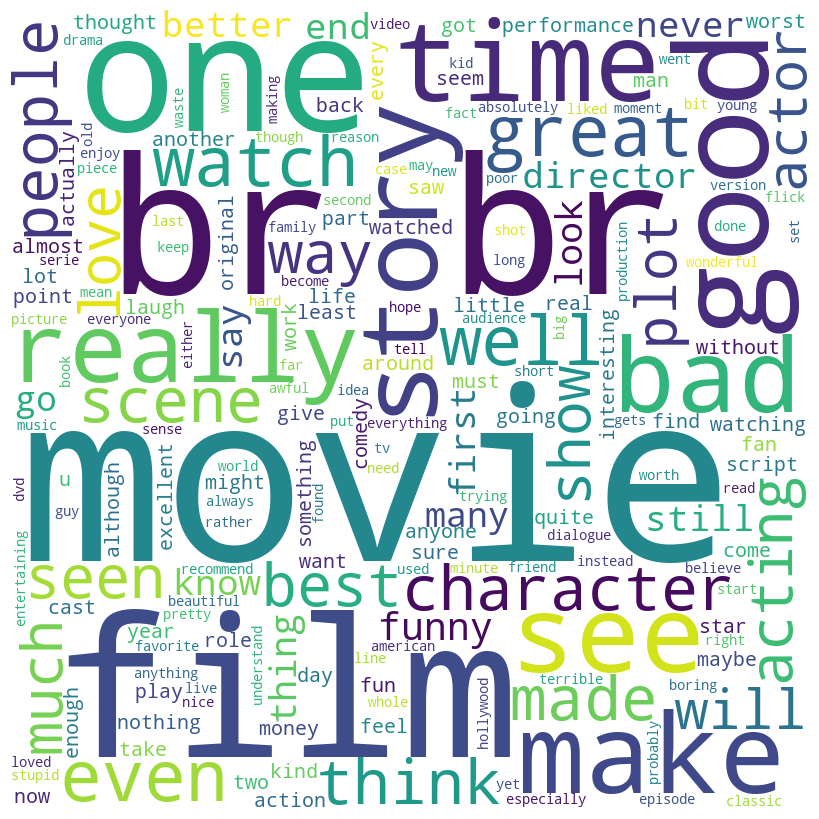

In [455]:
plot_word_cloud(train_validation_aug['text'])

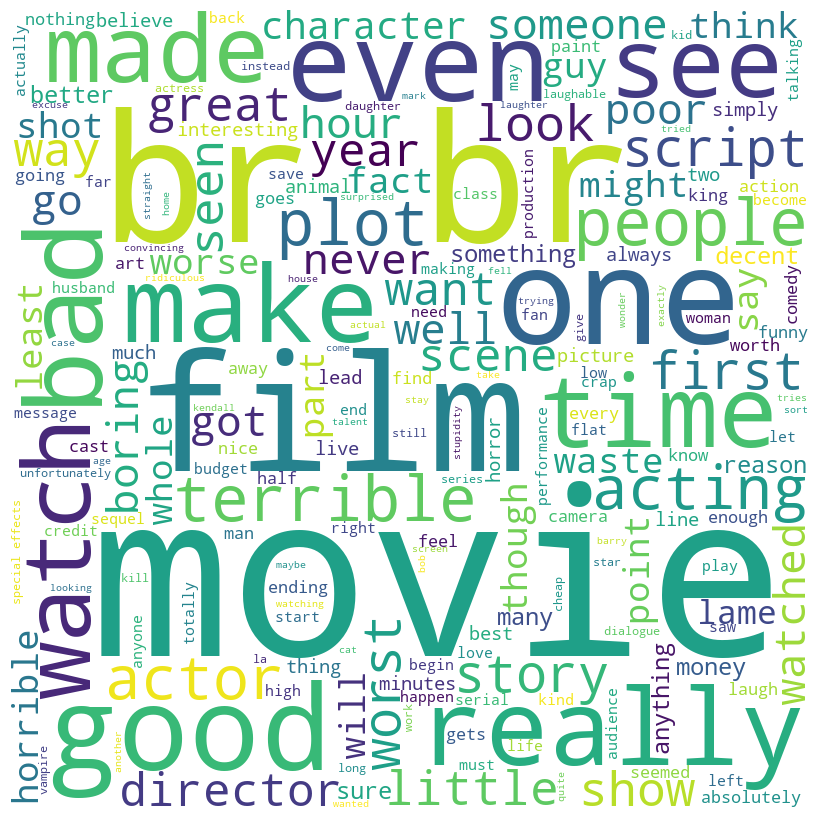

In [456]:
plot_word_cloud(train_validation_aug[train_validation_aug['label']==0]['text'])

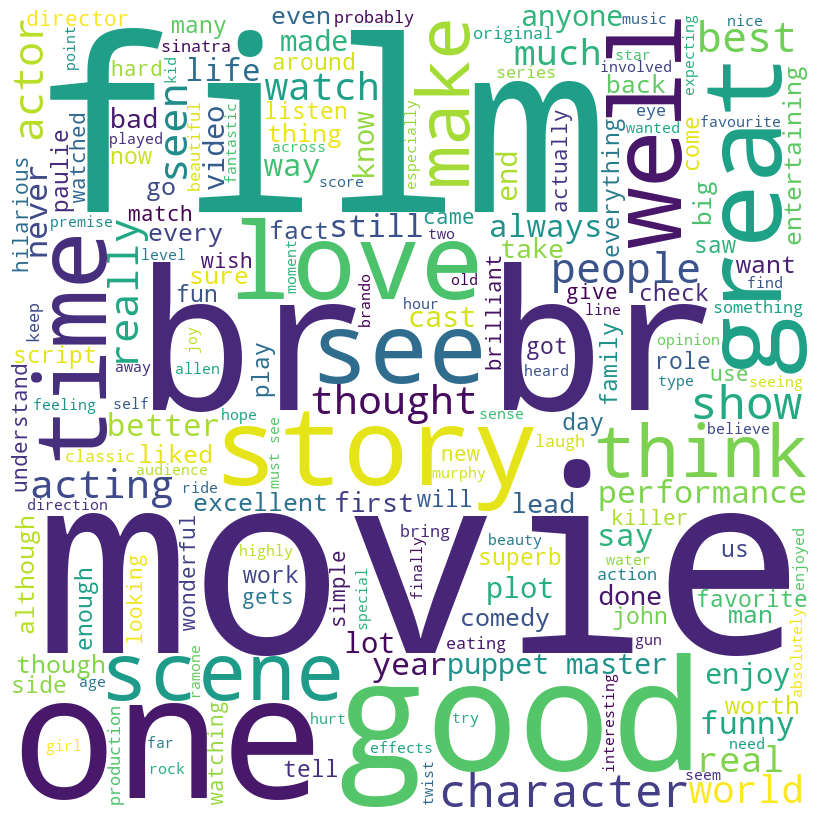

In [457]:
plot_word_cloud(train_validation_aug[train_validation_aug['label']==1]['text'])

# Feature Engineering

Methods for extracting features from text data:
* **Bag-of-words**: The bag-of-words model is a simple but effective feature extraction technique that counts the number of occurrences of each word in a document. This can be used to create a feature vector that represents the document.
* **N-grams**: N-grams are sequences of n words. N-grams can be used to create feature vectors that represent the order of words in a document.
* **TF-IDF**: TF-IDF stands for term frequency-inverse document frequency. TF-IDF is a weighting scheme that can be used to measure the importance of a word in a document.
* **Word embeddings**: Word embeddings are learned representations of words that capture the meaning of the words. Word embeddings can be used to create feature vectors that represent the meaning of words in a document.

# Semi-Supervised

## Using Traditional Methods (Label Propagation)

### Label Propagation Techniques

Label propagation techniques leverage the structure of the data to spread the labels from labeled to unlabeled points. The underlying assumption is that points that are close to each other or share some structural similarity are likely to have the same label. Key label propagation techniques include:

1. **Classic Label Propagation (LP):**
   - **Graph Construction:** Construct a graph where each node represents a data point and edges represent the similarity or distance between points.
   - **Initialization:** Initialize the labels of the labeled nodes and set the labels of the unlabeled nodes to a default value (often zero or some neutral value).
   - **Propagation:** Iteratively update the label of each node based on the labels of its neighbors. The process continues until convergence, i.e., when labels stop changing significantly.
   - **Final Assignment:** Assign labels to the unlabeled nodes based on the propagated labels.

2. **Label Spreading:**
   - Similar to label propagation but employs a normalized version of the propagation step to ensure the label distribution spreads more smoothly across the graph.
   - Emphasizes local consistency by incorporating both the label distribution of neighboring nodes and the original label information.

### Traditional Methods in Label Propagation

Traditional clustering methods like KMeans can be integrated into label propagation techniques to enhance the performance and efficiency. Here’s how KMeans and other traditional methods are used:

1. **KMeans Clustering:**
   - **Initial Clustering:** Apply KMeans clustering to the entire dataset (both labeled and unlabeled points) to form clusters.
   - **Cluster Labeling:** Assign labels to each cluster based on the majority label of the labeled points within the cluster. This step assumes that each cluster predominantly contains points of a single class.
   - **Label Propagation:** Use the cluster labels as initial labels for the label propagation algorithm, which then refines these labels by considering the local structure of the data.

2. **Graph-Based Methods:**
   - **K-Nearest Neighbors (KNN):** Construct a graph using KNN, where each node is connected to its k-nearest neighbors. The edges are weighted based on the distance or similarity between points.
   - **Graph Construction with KMeans:** Use KMeans to form clusters and then create a graph where nodes represent cluster centroids. This reduces the graph size and computational complexity.

3. **Spectral Clustering:**
   - **Graph Construction:** Construct a similarity graph and compute its Laplacian matrix.
   - **Eigen Decomposition:** Perform eigen decomposition on the Laplacian matrix to obtain a low-dimensional representation of the data.
   - **Clustering and Propagation:** Use a clustering algorithm (like KMeans) on the low-dimensional representation and propagate labels based on the cluster assignments.

### Advantages and Challenges

**Advantages:**
- **Efficiency:** Utilizing clustering methods like KMeans can significantly reduce the computational complexity by working on a reduced representation of the data.
- **Improved Accuracy:** Label propagation can improve the classification accuracy by leveraging the inherent structure of the data.
- **Scalability:** These techniques can handle large datasets effectively by combining graph-based methods with clustering algorithms.

**Challenges:**
- **Parameter Sensitivity:** The performance of label propagation methods can be sensitive to the choice of parameters, such as the number of clusters in KMeans or the number of neighbors in KNN.
- **Graph Construction:** Constructing a meaningful and efficient graph that accurately captures the data structure is crucial and can be computationally expensive.
- **Imbalanced Labels:** If the labeled data is not representative or is imbalanced, the propagated labels may not accurately reflect the true distribution of classes.

In summary, label propagation techniques in semi-supervised learning leverage the structure of the data to spread labels from a small labeled set to a larger unlabeled set. Traditional methods like KMeans can be integrated to enhance the efficiency and effectiveness of these techniques. However, careful consideration of parameters and graph construction is essential to achieve optimal performance.

In [247]:
class LabelPropagator():
    def get_array_values_from_df(self,df):
        return np.array([val for val in df])

    def _propagate(self,X_train,y_train,aug,thresh):
        X_train=self.get_array_values_from_df(X_train)
        X_aug=self.get_array_values_from_df(aug)
        X_aug,y_aug=self._get_labeled_aug(X_train,y_train,X_aug,thresh)
        return X_train,y_train,X_aug,y_aug

    def _get_labeled_aug(self,aug,thresh):
        pass

In [248]:
class MyLabelPropagator(LabelPropagator):
    def label_propagate(self,X_train,y_train,aug,k,thresh):
        self.model=KNeighborsClassifier(n_neighbors=k)
        X_train,y_train,X_aug,y_aug=self._propagate(X_train,y_train,aug,thresh)
        return np.concatenate([X_train,X_aug]),np.concatenate([y_train,y_aug])

    def _get_labeled_aug(self,X_train,y_train,aug,thresh):
        self.model.fit(X_train,y_train)
        predictions=self.model.predict(aug)
        predictions_accuracy=self.model.predict_proba(aug)
        X_aug=[]
        y_aug=[]
        for i,pred in enumerate(predictions):
            if (predictions_accuracy[i]).max()>thresh:
                X_aug.append(aug[i])
                y_aug.append(pred)
        return X_aug,y_aug

In [249]:
class SKLearnLabelPropagator(LabelPropagator):
    def label_propagate(self,X_train,y_train,aug,k,thresh):
        self.model=LabelPropagation(n_neighbors=k)
        X_train,y_train,X_aug,y_aug=self._propagate(X_train,y_train,aug,thresh)
        return np.concatenate([X_train,X_aug]),np.concatenate([y_train,y_aug])

    def _get_labeled_aug(self,X_train,y_train,aug,thresh):
        X=np.concatenate([X_train,aug])
        y=np.concatenate([y_train,np.full(len(aug),-1)])
        self.model.fit(X,y)
        predictions=self.model.transduction_[len(y_train):]
        predictions_accuracy=self.model.predict_proba(aug)
        X_aug=[]
        y_aug=[]
        for i,pred in enumerate(predictions):
            if (predictions_accuracy[i]).max()>thresh:
                X_aug.append(aug[i])
                y_aug.append(pred)
        return X_aug,y_aug

In [251]:
class SKLearnLabelSpreading(LabelPropagator):
    def label_propagate(self,X_train,y_train,aug,k,thresh=0.5):
        self.model=LabelSpreading(n_neighbors=k)
        X_train,y_train,X_aug,y_aug=self._propagate(X_train,y_train,aug,thresh)
        return np.concatenate([X_train,X_aug]),np.concatenate([y_train,y_aug])

    def _get_labeled_aug(self,X_train,y_train,aug,thresh):
        X=np.concatenate([X_train,aug])
        y=np.concatenate([y_train,np.full(len(aug),-1)])
        self.model.fit(X,y)
        predictions=self.model.transduction_[len(y_train):]
        predictions_accuracy=self.model.predict_proba(aug)
        X_aug=[]
        y_aug=[]
        for i,pred in enumerate(predictions):
            if (predictions_accuracy[i]).max()>thresh:
                X_aug.append(aug[i])
                y_aug.append(pred)
        return X_aug,y_aug

In [252]:
my_propagator=MyLabelPropagator()
X_validation=my_propagator.get_array_values_from_df(validation['embedding'])
y_validation=my_propagator.get_array_values_from_df(validation['label'])
X_train=[0]*9
y_train=[0]*9
X_train[0],y_train[0]=my_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],5,0.999999)
X_train[1],y_train[1]=my_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],3,0.99999999)
X_train[2],y_train[2]=my_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],9,0.9999999)
print(len(X_train[0]),len(X_train[1]),len(X_train[2]))

304 504 160


In [253]:
label_propagator=SKLearnLabelPropagator()
X_train[3],y_train[3]=label_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],21,0.99999)
X_train[4],y_train[4]=label_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],13,0.999999)
X_train[5],y_train[5]=label_propagator.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],1,0.9999999)
print(len(X_train[3]),len(X_train[4]),len(X_train[5]))

930 876 831


In [254]:
label_spreader=SKLearnLabelSpreading()
X_train[6],y_train[6]=label_spreader.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],5,0.99999999)
X_train[7],y_train[7]=label_spreader.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],21,0.9999999999)
X_train[8],y_train[8]=label_spreader.label_propagate(train['embedding'],train['label']
                                                                                    ,aug['embedding'],17,0.99999999999)
print(len(X_train[6]),len(X_train[7]),len(X_train[8]))

477 362 298


In [255]:
class MyClassifier:
    def report_scores(self, predicted_values, actual_values):
        print(f"Accuracy: {round(accuracy_score(actual_values,predicted_values),3)}")
        print(f"Recall: Micro: {round(recall_score(actual_values,predicted_values,average='micro'),3)}"+
                              f" Macro: {round(recall_score(actual_values,predicted_values,average='macro'),3)}"+
                              f" Weighted: {round(recall_score(actual_values,predicted_values,average='weighted'),3)}")
        print(f"Precision: Micro: {round(precision_score(actual_values,predicted_values,average='micro'),3)}"+
            f" Macro: {round(precision_score(actual_values,predicted_values,average='macro'),3)}"+
            f" Weighted: {round(precision_score(actual_values,predicted_values,average='weighted'),3)}")
        print(f"F1 score: Micro: {round(f1_score(actual_values,predicted_values,average='micro'),3)}"+
            f" Macro: {round(f1_score(actual_values,predicted_values,average='macro'),3)}"+
            f" Weighted: {round(f1_score(actual_values,predicted_values,average='weighted'),3)}")
        matrix=confusion_matrix(actual_values,predicted_values)
        sns.heatmap(matrix, annot=True, cmap="flare")

    def fit(self,X, y):
        self.model.fit(X,y)

    def predict(self,X):
        return self.model.predict(X)

    def fit_predict_report(self,X_train,y_train,X_test,y_test):
        self.fit(X_train,y_train)
        predictions = self.predict(X_test)
        self.report_scores(predictions, y_test)

    def randomized_search_params(self,param_distributions, X, y,n_iter=10):
        return RandomizedSearchCV(self.model, param_distributions=param_distributions,n_iter=n_iter).fit(X, y)

In [256]:
class MyKNNClassifier(MyClassifier):
    def __init__(self) -> None:
        super().__init__()
        self.model = KNeighborsClassifier()
    def set_params(self, params):
        self.model = KNeighborsClassifier(n_neighbors=params['n_neighbors'],metric=params['metric'])

In [257]:
def report_best_scores_from_labels(X_train,y_train,X_test,y_test,model,params,n_iter=10):
    best_score=0
    best_params=None
    best_i=0
    for i in range(len(X_train)):
        search = model.randomized_search_params(params,X_train[i], y_train[i],n_iter=n_iter)
        if search.best_score_>best_score:
            best_score=search.best_score_
            best_params=search.best_params_
            best_i=i
    print(f'The {best_i}th train set got the best results')
    model.set_params(best_params)
    model.fit_predict_report(X_train[best_i], y_train[best_i],X_test,y_test)

The 1th train set got the best results
Accuracy: 0.767
Recall: Micro: 0.767 Macro: 0.706 Weighted: 0.767
Precision: Micro: 0.767 Macro: 0.722 Weighted: 0.76
F1 score: Micro: 0.767 Macro: 0.713 Weighted: 0.763


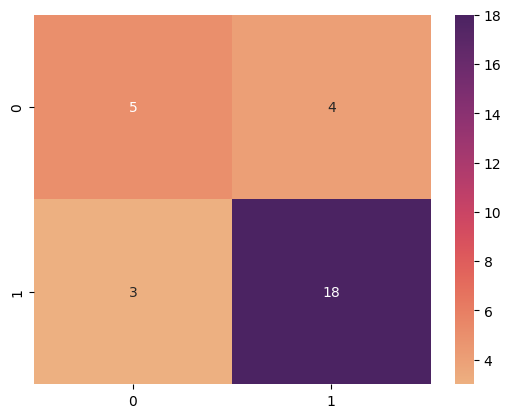

In [258]:
KNN_model=MyKNNClassifier()
KNN_params={'n_neighbors': np.arange(1, 10),
    'metric': ['euclidean', 'l1', 'minkowski', 'hamming',
                'l2', 'p', 'infinity', 'cityblock',
                  'sqeuclidean', 'braycurtis', 'correlation', 'cosine',
                    'nan_euclidean', 'manhattan', 'chebyshev', 'canberra']}
report_best_scores_from_labels(X_train,y_train,X_validation,y_validation,KNN_model,KNN_params)

In [259]:
class MyRandomForestClassifier(MyClassifier):
    def __init__(self, random_state) -> None:
        super().__init__()
        self.model = RandomForestClassifier(oob_score=False, n_jobs=-1,random_state=random_state)
        self.random_state=random_state

    def set_params(self, params) -> None:
        self.model = RandomForestClassifier(oob_score=False,n_jobs=-1,n_estimators=params['n_estimators'],
                                            max_features=params['max_features'],
                                            min_samples_leaf=params['min_samples_leaf'],random_state=self.random_state)

    def plot_feature_importance(self, columns) -> None:
        plt.figure(figsize=(8, 6))
        plt.bar(columns, self.model.feature_importances_)
        plt.show()

The 1th train set got the best results
Accuracy: 0.8
Recall: Micro: 0.8 Macro: 0.794 Weighted: 0.8
Precision: Micro: 0.8 Macro: 0.766 Weighted: 0.817
F1 score: Micro: 0.8 Macro: 0.775 Weighted: 0.805


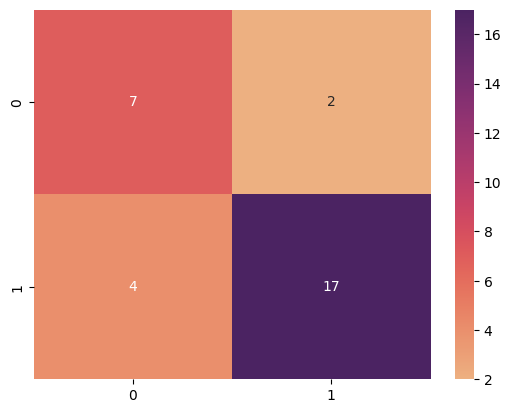

In [260]:
random_forest_model=MyRandomForestClassifier(random_state)
random_forest_params={'n_estimators': np.arange(70, 101, 20),
     'max_features': np.arange(7, 12),
     'min_samples_leaf': np.arange(1, 5)}
report_best_scores_from_labels(X_train,y_train,X_validation,y_validation,random_forest_model,random_forest_params)

In [261]:
class MyXGBoostClassifier(MyClassifier):
    def __init__(self, random_state) -> None:
        super().__init__()
        self.model = xgb.XGBClassifier(random_state=random_state)
        self.random_state=random_state

    def set_params(self, params) -> None:
        self.model = xgb.XGBClassifier(
            learning_rate=params['learning_rate'], max_depth=params['max_depth'],
            min_child_weight=params['min_child_weight'], colsample_bytree=params['colsample_bytree'],
            n_estimators=params['n_estimators'],random_state=self.random_state)

    def plot_feature_importance(self, columns) -> None:
        plt.figure(figsize=(8, 6))
        plt.bar(columns, self.model.feature_importances_)
        plt.show()

The 0th train set got the best results
Accuracy: 0.867
Recall: Micro: 0.867 Macro: 0.841 Weighted: 0.867
Precision: Micro: 0.867 Macro: 0.841 Weighted: 0.867
F1 score: Micro: 0.867 Macro: 0.841 Weighted: 0.867


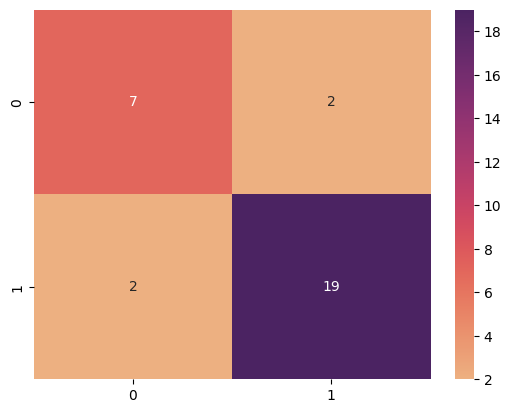

In [262]:
XGBoost_model = MyXGBoostClassifier(random_state)
XGBoost_params = {"learning_rate": stats.distributions.uniform(loc=0.5, scale=0.5),
     "max_depth": stats.randint(1, 100), "min_child_weight": stats.randint(1, 100),
     "colsample_bytree": stats.distributions.uniform(loc=0.5, scale=0.5), "n_estimators": stats.randint(1, 1000)}
report_best_scores_from_labels(X_train,y_train,X_validation,y_validation,XGBoost_model,XGBoost_params,n_iter=2)

In [263]:
class MySVMClassifier(MyClassifier):
    def __init__(self) -> None:
        super().__init__()
        self.model = SVC()

    def set_params(self,params):
        self.model = SVC(kernel=params['kernel'],C=params['C'], degree=params['degree'])

The 1th train set got the best results
Accuracy: 0.833
Recall: Micro: 0.833 Macro: 0.786 Weighted: 0.833
Precision: Micro: 0.833 Macro: 0.807 Weighted: 0.83
F1 score: Micro: 0.833 Macro: 0.795 Weighted: 0.83


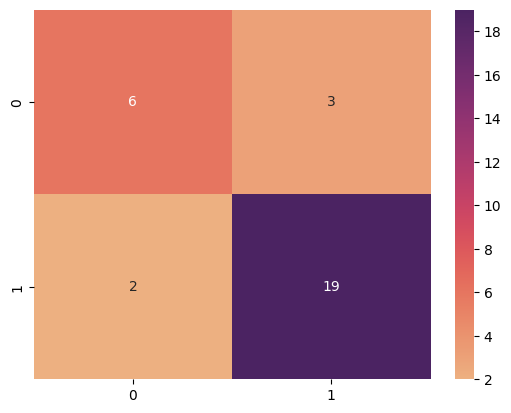

In [264]:
SVM_model = MySVMClassifier()
SVM_params = {'kernel':['linear','rbf'],'C': stats.distributions.uniform(loc=100, scale=1000),'degree': stats.randint(1, 100)}
report_best_scores_from_labels(X_train,y_train,X_validation,y_validation,SVM_model,SVM_params)

In [265]:
def default_fit_predict_report(model,params_dict,X_train,y_train,X_test,y_test,n_iter=20):
    params=model.randomized_search_params(params_dict,X_train,y_train,n_iter=n_iter).best_params_
    model.set_params(params)
    model.fit_predict_report(X_train,y_train,X_test,y_test)

In [266]:
X_train_validation=np.concatenate((X_train[0],X_validation))
y_train_validation=np.concatenate((y_train[0],y_validation))
X_test=my_propagator.get_array_values_from_df(test['embedding'])
y_test=my_propagator.get_array_values_from_df(test['label'])

Accuracy: 0.693
Recall: Micro: 0.693 Macro: 0.69 Weighted: 0.693
Precision: Micro: 0.693 Macro: 0.696 Weighted: 0.695
F1 score: Micro: 0.693 Macro: 0.69 Weighted: 0.691


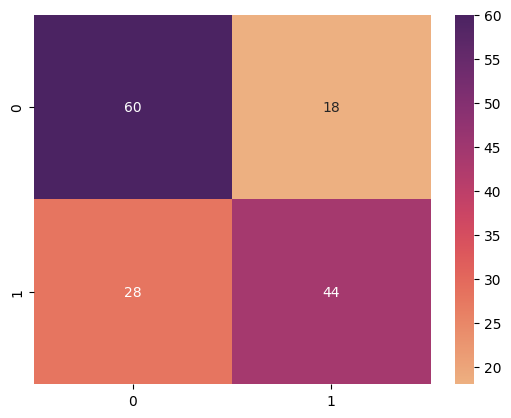

In [267]:
default_fit_predict_report(KNN_model,KNN_params,X_train_validation,y_train_validation,X_test,y_test)

Accuracy: 0.733
Recall: Micro: 0.733 Macro: 0.731 Weighted: 0.733
Precision: Micro: 0.733 Macro: 0.735 Weighted: 0.735
F1 score: Micro: 0.733 Macro: 0.731 Weighted: 0.732


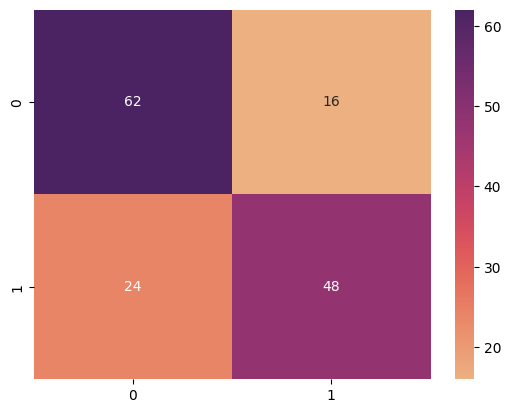

In [268]:
default_fit_predict_report(random_forest_model,random_forest_params,X_train_validation,y_train_validation,X_test,y_test)

Accuracy: 0.753
Recall: Micro: 0.753 Macro: 0.753 Weighted: 0.753
Precision: Micro: 0.753 Macro: 0.753 Weighted: 0.753
F1 score: Micro: 0.753 Macro: 0.753 Weighted: 0.753


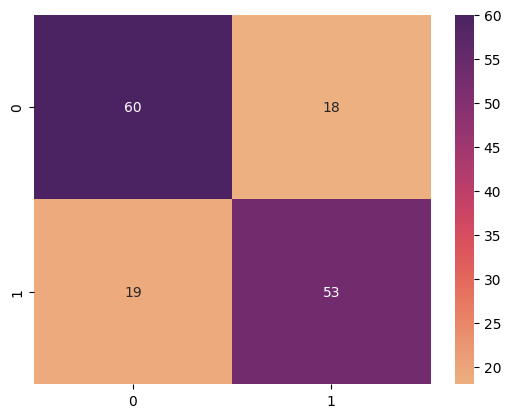

In [269]:
default_fit_predict_report(SVM_model,SVM_params,X_train_validation,y_train_validation,X_test,y_test)

Accuracy: 0.747
Recall: Micro: 0.747 Macro: 0.744 Weighted: 0.747
Precision: Micro: 0.747 Macro: 0.751 Weighted: 0.75
F1 score: Micro: 0.747 Macro: 0.744 Weighted: 0.745


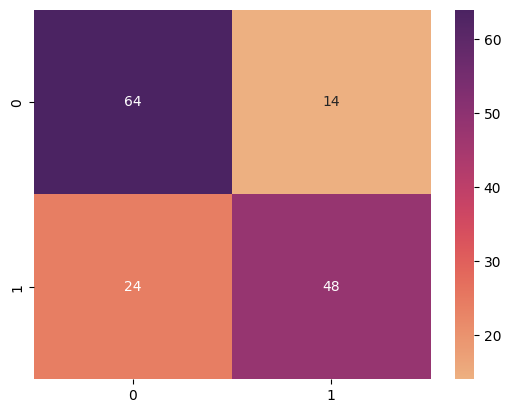

In [270]:
default_fit_predict_report(XGBoost_model,XGBoost_params,X_train_validation,y_train_validation,X_test,y_test)

In [271]:
original_X_train=my_propagator.get_array_values_from_df(train['embedding'])
original_y_train=my_propagator.get_array_values_from_df(train['label'])

Accuracy: 0.72
Recall: Micro: 0.72 Macro: 0.713 Weighted: 0.72
Precision: Micro: 0.72 Macro: 0.744 Weighted: 0.742
F1 score: Micro: 0.72 Macro: 0.708 Weighted: 0.711


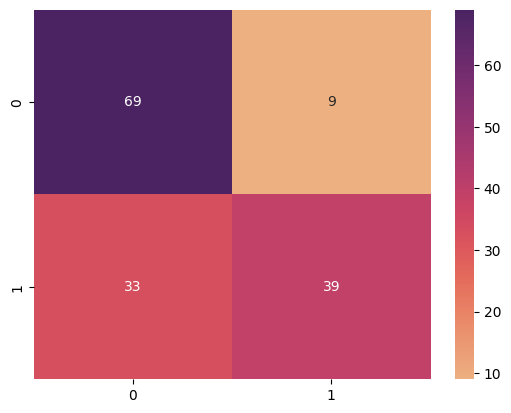

In [272]:
default_fit_predict_report(KNN_model,KNN_params,original_X_train,original_y_train,X_test,y_test)

Accuracy: 0.72
Recall: Micro: 0.72 Macro: 0.722 Weighted: 0.72
Precision: Micro: 0.72 Macro: 0.722 Weighted: 0.724
F1 score: Micro: 0.72 Macro: 0.72 Weighted: 0.72


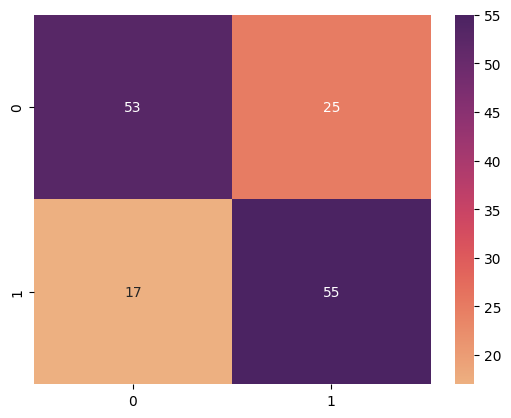

In [273]:
default_fit_predict_report(random_forest_model,random_forest_params,original_X_train,original_y_train,X_test,y_test)

Accuracy: 0.74
Recall: Micro: 0.74 Macro: 0.74 Weighted: 0.74
Precision: Micro: 0.74 Macro: 0.74 Weighted: 0.741
F1 score: Micro: 0.74 Macro: 0.74 Weighted: 0.74


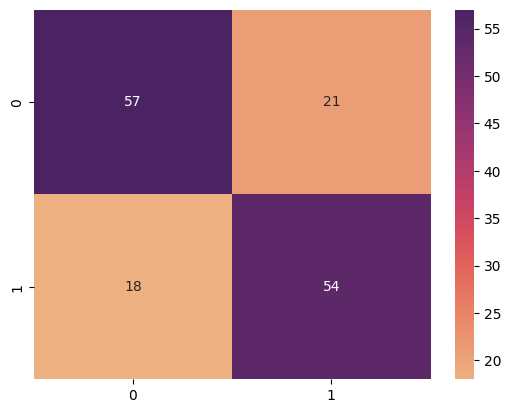

In [274]:
default_fit_predict_report(SVM_model,SVM_params,original_X_train,original_y_train,X_test,y_test)

Accuracy: 0.673
Recall: Micro: 0.673 Macro: 0.676 Weighted: 0.673
Precision: Micro: 0.673 Macro: 0.677 Weighted: 0.679
F1 score: Micro: 0.673 Macro: 0.673 Weighted: 0.673


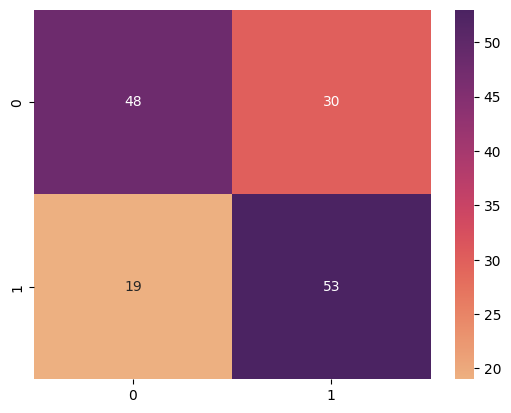

In [275]:
default_fit_predict_report(XGBoost_model,XGBoost_params,original_X_train,original_y_train,X_test,y_test)

## Using LLMs

### Load model

In [ ]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16 # add torch.
}
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def load_model(model_args):


    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'], #remove torch.
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

In [ ]:
model, tokenizer = load_model(MODEL_ARGS)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def generate_text(model, tokenizer, prompt, max_new_tokens = 100, do_sample=True, temperature=0.5):

    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    if do_sample:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=temperature)
    else:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=do_sample)

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return output_text[len(prompt):]

In [ ]:
train_prompt = [f"""Question: {train.iloc[-2]['text']}
Answer: 0
This comment is predominantly negative, and here are the reasons:

1. **Emotional Reactions**: The commenter describes intensely negative emotional reactions, such as almost crying and feeling the urge to vomit, due to the disturbing content.
2. **Content Descriptions**: The specifics mentioned, such as self-harm, a late-term abortion with rusty utensils, and animal cruelty, are portrayed in a negative light and described as gruesome and disturbing.
3. **Positive Elements Are Limited and Qualified**: While the commenter mentions that they found the baby "adorable in its own twisted little way" and that they are intrigued to see the sequel, these positive notes are heavily qualified by the context of the overall negative experience.
4. **Final Sentiment**: Despite the intrigue for the sequel, the overarching sentiment conveyed through the description of the disturbing and gruesome scenes is predominantly negative.

Therefore, the negative aspects of the comment outweigh the few qualified positive remarks, making the overall tone of the comment negative.
Question: {train.iloc[-3]['text']}
Answer: 0
This comment is clearly negative. Here are the reasons:

Overall Sentiment: The commenter starts by labeling the film as "the worst film" they've ever viewed, setting a distinctly negative tone from the outset.
Critique of Elements: They criticize multiple aspects of the film, including the acting, plot, character portrayal, and overall execution, describing them as exaggerated, poor, and ridiculous.
Disappointment and Regret: They express regret about their time, money, and energy spent on the film, even suggesting that making a home movie would be a better use of resources.
Surprise at Production and Distribution: The commenter is surprised that money was spent to make and distribute the film, indicating a low opinion of its quality and value.
Overall, the comment consistently conveys dissatisfaction and disappointment, making it clearly negative.
Question: {train.iloc[-4]['text']}
Answer: 1
This comment is clearly positive. Here are the reasons:

Expresses Preference: The commenter states that the movie is one of their favorites of all time, indicating a strong positive opinion.
Praises Specific Elements: They commend the dialogue, cast, and plot, using words like "very tight," "superb," and "highly original" to describe these aspects positively.
Encourages Viewing: The commenter encourages others to watch and enjoy the movie, suggesting they believe others will also have a positive experience.
Overall, the tone and content of the comment are enthusiastic and approving, making it unmistakably positive.
Question: {train.iloc[-5]['text']}
Answer: 1
This comment is positive. Here are the reasons:

1. **Initial Expectation vs. Reality**: The commenter mentions they had a low expectation initially but then acknowledges that the movie turned out to be good.
2. **Positive Evaluation**: The comment explicitly states, "I thought this movie was good" and rates it 8/10, which is a high rating.
3. **Praise for Actress**: The commenter also adds a positive note about Michelle Rodriguez, implying her presence adds value to the film.

Overall, the positive remarks about the movie's quality, the high rating, and the compliment to the actress make the comment clearly positive.
"""]

In [ ]:
def generate_labels(df,train_prompt,start,end):
  all_labels=[]
  with tqdm(total=len(df)) as pbar:
    for j in range(start,end):
      labels=[]
      for i in range(j*len(df)//end,(j+1)*len(df)//end):
        instruction_prompt='Instruction: For ech comment write 1 if the comment is positive else write 0 if it is negative it cannot be something in between. Write just 0 or 1 as first charracter no other number then give reason for it.\n'
        valid_prompt=f"""Question: {df.iloc[i]['text']}
        Answer:"""
        prompt = instruction_prompt+'\n'.join(train_prompt)+'\n'+valid_prompt
        label=generate_text(
          model=model,
          tokenizer=tokenizer,
          prompt=prompt,
          max_new_tokens=5,
          do_sample=False,
          temperature=0.0,
        )
        labels.append(label)
        pbar.update(1)
      with open(f'labels/labels{j}.txt', 'w') as fp:
        for label in labels:
          fp.write("%s\n" % label)
      all_labels.extend(labels)
  return all_labels

In [ ]:
generated_labels=generate_labels(validation,train_prompt,0,10)

100%|██████████| 30/30 [02:42<00:00,  5.40s/it]


In [ ]:
in_correct=0
correct=0
no_label=0
for i in range(len(generated_labels)):
  if not (generated_labels[i].strip()[0]).isnumeric():
    no_label+=1
  elif validation.iloc[i]['label']==(int(generated_labels[i].strip()[0])):
    correct+=1
  else:
    in_correct+=1
print(f'Number of correctly predicted labels: {correct}')
print(f'Number of incorrectly predicted labels: {in_correct}')
print(f'Number of labels not predicted: {no_label}')

Number of correctly predicted labels: 29
Number of incorrectly predicted labels: 1
Number of labels not predicted: 0


In [ ]:
generated_labels=generate_labels(aug,train_prompt,10)

100%|██████████| 1014/1014 [1:31:12<00:00,  5.40s/it]


In [276]:
generated_labels=[]
for i in range(10):
    f = open(f"labels/labels{i}.txt", "r")
    for x in f:
        for c in x:
            if c.isnumeric():
                generated_labels.append(int(c))
    f.close()
len(generated_labels)

1014

In [277]:
X_train=my_propagator.get_array_values_from_df(pd.concat([train['embedding'],aug['embedding']],ignore_index=True))
y_train=my_propagator.get_array_values_from_df(pd.concat([train['label'],pd.Series(generated_labels)],ignore_index=True))
X_test=my_propagator.get_array_values_from_df(test['embedding'])
y_test=my_propagator.get_array_values_from_df(test['label'])

Accuracy: 0.76
Recall: Micro: 0.76 Macro: 0.757 Weighted: 0.76
Precision: Micro: 0.76 Macro: 0.764 Weighted: 0.763
F1 score: Micro: 0.76 Macro: 0.757 Weighted: 0.758


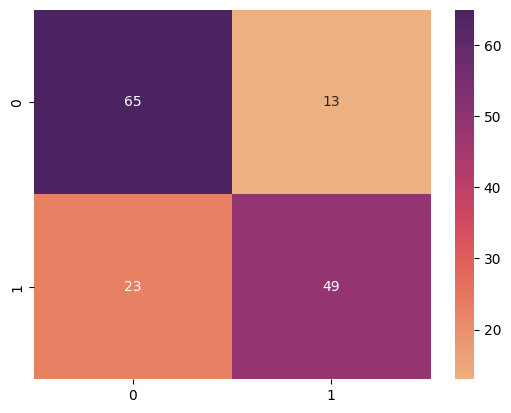

In [278]:
default_fit_predict_report(KNN_model,KNN_params,X_train,y_train,X_test,y_test)

Accuracy: 0.773
Recall: Micro: 0.773 Macro: 0.775 Weighted: 0.773
Precision: Micro: 0.773 Macro: 0.776 Weighted: 0.777
F1 score: Micro: 0.773 Macro: 0.773 Weighted: 0.773


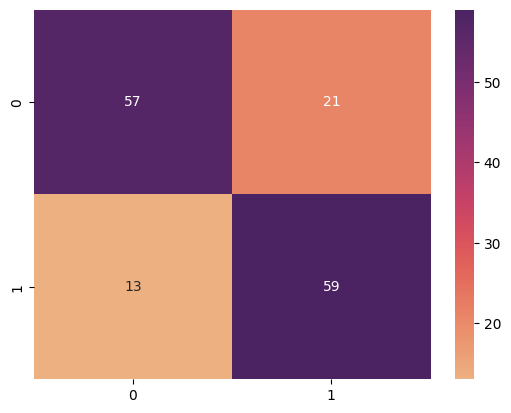

In [279]:
default_fit_predict_report(random_forest_model,random_forest_params,X_train,y_train,X_test,y_test)

Accuracy: 0.847
Recall: Micro: 0.847 Macro: 0.848 Weighted: 0.847
Precision: Micro: 0.847 Macro: 0.847 Weighted: 0.849
F1 score: Micro: 0.847 Macro: 0.847 Weighted: 0.847


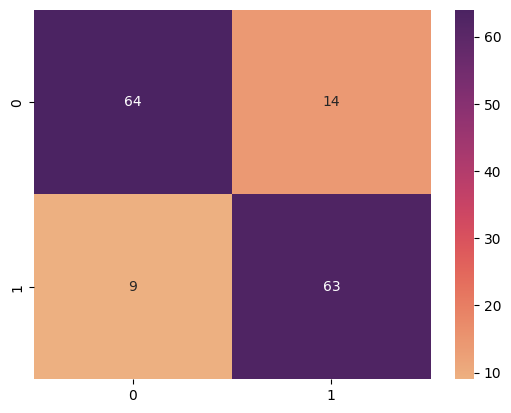

In [280]:
default_fit_predict_report(SVM_model,SVM_params,X_train,y_train,X_test,y_test)

Accuracy: 0.807
Recall: Micro: 0.807 Macro: 0.807 Weighted: 0.807
Precision: Micro: 0.807 Macro: 0.807 Weighted: 0.807
F1 score: Micro: 0.807 Macro: 0.807 Weighted: 0.807


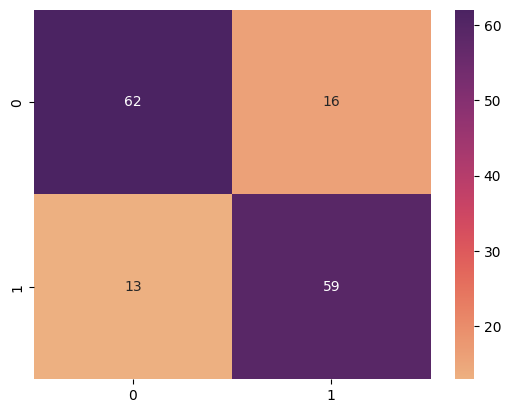

In [281]:
default_fit_predict_report(XGBoost_model,XGBoost_params,X_train,y_train,X_test,y_test)

# Questions

1. Research semi-supervised problems and explain how to select a proportion of data
for manual labeling. Does the choice of data matter?

Selecting a proportion of data for manual labeling in semi-supervised learning is a crucial step that can significantly impact the performance of the model. The choice of data for labeling should be strategic to maximize the efficiency and effectiveness of the labeling process. Here are some common strategies:
* **Random Sampling**: Description: Randomly selecting data points from the unlabeled dataset.\
Advantages: Simple to implement and does not require prior knowledge of the data.\
Disadvantages: May not always be the most efficient in terms of improving model performance.
* **Uncertainty Sampling**: Description: Selects data points where the model is least certain about its predictions. This can be determined by looking at the prediction probabilities.\
Advantages: Focuses on the most informative samples, which can lead to faster model improvement.\
Disadvantages: Requires an initial model to estimate uncertainty, which might not be accurate in the beginning stages.
* **Diversity Sampling**: Description: Selects data points that are diverse and representative of the entire dataset. This can be achieved using clustering techniques.\
Advantages: Ensures a wide range of examples, potentially covering different aspects of the data distribution.\
Disadvantages: More complex to implement and computationally intensive.
* **Error-Based Sampling**: Description: Selects data points where the model makes the most errors or has the highest loss.\
Advantages: Directly targets the weaknesses of the model.\
Disadvantages: Similar to uncertainty sampling, it requires an initial model.
* **Hybrid Approaches**: Description: Combines multiple strategies, such as uncertainty and diversity sampling.\
Advantages: Can balance the strengths of different approaches.\
Disadvantages: More complex and may require fine-tuning.

**Does the Choice of Data Matter?**\
Yes, the choice of data for manual labeling matters significantly in semi-supervised learning. Here’s why:
* **Model Performance**: Selecting the right data points can lead to faster and more significant improvements in model accuracy. For instance, labeling uncertain or misclassified samples can help the model learn from its mistakes more effectively.
* **Efficiency**: Strategic selection of data can reduce the amount of labeled data required to achieve a given performance level, saving time and resources.
* **Representation**: Ensuring that labeled data is representative of the overall data distribution helps in creating a more generalizable model. If only a specific subset of data is labeled, the model might perform well on that subset but poorly on other parts of the dataset.
* **Reducing Bias**: Careful selection can help in reducing biases that may arise from an imbalanced or unrepresentative labeled dataset. This is crucial for creating fair and accurate models.

2. For label propagation, how many data points did you label using your manually labeled
data? Explain the trade-off between quality and quantity of your labeled data

By testing different amounts the best results we got the best results when we used Knn model with 5 neighbors and threshold of 0.999999 which gave us 304 labels.

**Advantages of High-Quality Labeled Data**:
* **Improved Model Performance**: Models trained on accurate and informative data tend to generalize better and achieve higher accuracy.
* **Efficient Learning**: Even a small amount of high-quality labeled data can significantly improve the model, reducing the need for large quantities of data.
* **Robustness**: Helps in building more robust models that perform well on unseen data.

**Challenges of High-Quality Labeled Data**:
* **Cost and Time**: Acquiring high-quality labeled data is often expensive and time-consuming, especially if expert knowledge is required for labeling.
* **Availability**: High-quality labeled data might not always be available, particularly in specialized or emerging domains.

**Advantages of Large Quantities of Labeled Data**:
* **Improved Learning**: Having more data generally provides the model with more information to learn from, potentially leading to better performance.
* **Better Representation**: Larger datasets are more likely to capture the full diversity of the data distribution, reducing the risk of overfitting to a small subset.

**Challenges of Large Quantities of Labeled Data**:
* **Cost and Time**: Labeling large datasets can be prohibitively expensive and time-consuming.
* **Diminishing Returns**: Beyond a certain point, adding more labeled data may yield diminishing returns in terms of model performance improvement.
* **Quality Control**: Ensuring the quality of a large dataset can be challenging. Poor quality labels can introduce noise and degrade model performance.

3. Research the limitations of label propagation methods. Can these limitations be
overcome using a large language model (LLM)? If yes, explain how and why using
LLMs is more effective for these tasks

**Limitations of Label Propagation Methods**:
* **Graph Construction Complexity**:\
Constructing an accurate and representative graph that captures the underlying data structure can be complex and computationally expensive.
* **Scalability Issues**:\
Label propagation algorithms can struggle with scalability, especially for large datasets, as the graph construction and label propagation processes are computationally intensive.
* **Sensitivity to Graph Structure**:\
The performance of label propagation heavily depends on the quality of the graph. Poorly constructed graphs with incorrect or noisy connections can lead to incorrect label propagation.
* **Class Imbalance**:\
Label propagation can be biased towards classes that are more connected or have more labeled examples, leading to poor performance on underrepresented classes.
* **Assumption of Smoothness**:\
Label propagation assumes that similar data points have similar labels, which may not hold in all cases, particularly in high-dimensional or complex datasets.
* **Propagation of Errors**:\
Errors in the initial labeling can propagate through the graph, leading to widespread mislabeling.

**Using Large Language Models (LLMs) to Overcome Limitations**
* **Enhanced Feature Representation**:\
LLMs provide rich and contextualized representations of data, capturing complex relationships and nuances that simple graph-based methods might miss. This can lead to better initial feature extraction, which can then be used to construct more accurate graphs for label propagation.
* **Scalability**:\
LLMs, especially when used in conjunction with modern computational resources, can handle large-scale data efficiently. Techniques such as distributed computing and model parallelism can help manage large datasets more effectively than traditional label propagation methods.
* **Reduced Sensitivity to Graph Structure**:\
By leveraging the contextual understanding of LLMs, the reliance on a manually constructed graph is reduced. LLMs can infer relationships between data points based on learned representations, potentially bypassing the need for an explicit graph structure.
* **Handling Class Imbalance**:\
LLMs can be fine-tuned or used in conjunction with techniques that address class imbalance, such as over-sampling underrepresented classes or using loss functions that account for class distribution. This reduces the bias towards more connected classes.
* **Robustness to Noise**:\
The pre-trained nature of LLMs and their ability to generalize from large amounts of data make them more robust to noise in the dataset. They can better handle mislabeled data points and reduce the propagation of errors.
* **Active Learning Integration**:\
LLMs can be integrated into active learning frameworks to intelligently select the most informative data points for labeling. This selective approach can improve the overall quality of the labeled dataset and make the label propagation process more efficient and accurate.

**Why LLMs are More Effective?**
* **Pre-trained Knowledge**:\
LLMs are pre-trained on vast amounts of data, allowing them to understand language and context at a deep level. This pre-trained knowledge can be leveraged to enhance semi-supervised learning tasks.
* **Contextual Understanding**:\
Unlike traditional methods that rely heavily on explicit graph structures, LLMs use contextual information to understand relationships and similarities between data points, leading to more accurate and meaningful label propagation.
* **Versatility**:
LLMs can be fine-tuned for specific tasks, making them versatile tools for a wide range of applications. Their adaptability allows them to be used in various semi-supervised learning scenarios beyond what traditional label propagation methods can handle.
* **Integration with Modern Techniques**:
LLMs can be combined with other modern machine learning techniques, such as transfer learning, few-shot learning, and self-supervised learning, to further enhance their performance in semi-supervised learning tasks.

4. Research the history of language modeling, their evolution, and explain how they work.
Discuss the advantages and limitations of language models, especially large language
models (LLMs), in various tasks.

**History of Language Modeling**

**Early Beginnings**:\
`1950s-1970s`: Language models (LMs) began with rule-based approaches and statistical methods. The earliest models were based on n-grams, which predict the next word in a sequence based on the previous n−1 words. For instance, a bigram model looks at one preceding word.
`1980s-1990s`: Introduction of probabilistic models like Hidden Markov Models (HMMs) and advances in computational linguistics. These models used statistical techniques to model sequences and were applied in tasks like speech recognition and part-of-speech tagging.\
**Neural Network Era**:\
`2000s`: The introduction of neural networks brought significant improvements. Early neural language models (e.g., Bengio et al., 2003) used feedforward networks to predict word sequences, capturing more complex patterns than n-grams.
`2010s`: Recurrent Neural Networks (RNNs), particularly Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRUs), became popular. These models could capture dependencies across longer sequences, overcoming limitations of earlier models.\
**Transformers and Large Language Models**:\
`2017`: The transformer architecture was introduced by Vaswani et al. in the paper "Attention is All You Need." Transformers utilize self-attention mechanisms, allowing them to process entire sequences simultaneously and capture long-range dependencies more effectively than RNNs.
`2018-Present`: Transformers paved the way for large language models (LLMs) like OpenAI's GPT series, BERT (Bidirectional Encoder Representations from Transformers), and other models like T5 and BART. These models are pre-trained on vast amounts of text data and fine-tuned for specific tasks.

**How Language Models Work**

**Mechanism**: Predict the probability of a word based on the previous n−1 words using counts from a corpus.
Limitation: Limited context and issues with sparse data.
**Feedforward Networks**: Use neural networks to predict the next word in a sequence, considering a fixed window of previous words.
RNNs and LSTMs: Capture sequential dependencies using recurrent connections that maintain a hidden state representing the sequence history.
**Transformers**: Use self-attention mechanisms to weigh the importance of different words in a sequence, allowing for parallel processing and capturing long-range dependencies.

**Advantages of Language Models**

**General Advantages**:\
**Contextual Understanding**: Modern LMs capture complex linguistic patterns and contextual nuances, improving performance on tasks like translation, summarization, and question answering.\
**Transfer Learning**: Pre-trained LMs can be fine-tuned on specific tasks, leveraging vast amounts of general knowledge encoded during pre-training.\
**Scalability**: Large language models scale well with more data and parameters, continuously improving with more resources.\
**Advantages of Large Language Models (LLMs)**:\
**State-of-the-Art Performance**: Achieve top results on benchmarks for various NLP tasks.\
**Versatility**: Can be applied to a wide range of applications, from chatbots and virtual assistants to content generation and code completion.\
**Few-Shot Learning**: Capable of performing tasks with minimal task-specific data, often using examples provided in the input.
Limitations of Language Models\
**General Limitations**:\
**Data Dependency**: High-quality performance relies on large, diverse datasets. Biased or insufficient data can lead to poor generalization.\
**Computational Resources**: Training and fine-tuning LMs require significant computational power and memory, making them expensive to develop and deploy.

**Limitations of Large Language Models (LLMs)**:

**Bias and Fairness**: LLMs can amplify and propagate biases present in the training data, leading to ethical and fairness issues.
Interpretability: Large models are often black boxes, making it difficult to understand their decision-making processes.\
**Resource Intensive**: Training and maintaining LLMs require extensive computational resources, which can be environmentally and economically costly.\
**Overfitting**: Despite their size, LLMs can still overfit to specific patterns in the training data, limiting their generalizability.\
**Dependence on Pre-Training**: LLMs rely heavily on pre-training data quality. Poor pre-training data can result in suboptimal performance.\
**Applications of Language Models**\
**Machine Translation**: Translate text between languages with high accuracy (e.g., Google Translate).\
**Text Summarization**: Generate concise summaries of long texts.\
**Sentiment Analysis**: Determine the sentiment of text, useful in social media monitoring and customer feedback analysis.\
**Chatbots**: Provide customer support and information retrieval.\
**Virtual Assistants**: Perform tasks like scheduling, reminders, and information lookup (e.g., Siri, Alexa).\
**Text Generation**: Create human-like text for writing assistance, creative content, and marketing copy.\
**Code Generation**: Assist in programming by generating code snippets and completing functions (e.g., GitHub Copilot).\
**Search Engines**: Improve search results by understanding user queries more contextually.

5. For each method (LLM/Label-Propagation), explain its advantages and
disadvantages.

**Large Language Models (LLMs)**

**Advantages**:

**Contextual Understanding**: LLMs capture complex linguistic patterns and contextual nuances, improving performance on tasks like translation, summarization, and question answering.\
**Transfer Learning**: Pre-trained LLMs can be fine-tuned on specific tasks, leveraging vast amounts of general knowledge encoded during pre-training.\
**Versatility**: LLMs can be applied to a wide range of applications, from chatbots and virtual assistants to content generation and code completion.\
**Few-Shot Learning**: LLMs can perform tasks with minimal task-specific data, often using examples provided in the input.
Benefit: Allows for quick adaptation to new tasks without extensive retraining.

**Disadvantages**:

**Bias and Fairness**: LLMs can amplify and propagate biases present in the training data.\
**Interpretability**: LLMs are often black boxes, making it difficult to understand their decision-making processes.\
**Resource Intensive**: Training and maintaining LLMs require extensive computational resources and memory.\
**Dependence on Pre-Training Data Quality**: LLMs rely heavily on the quality of pre-training data.\
**Scalability of Deployment**: While LLMs can handle large datasets during training, deploying them in real-time applications can be challenging due to latency and storage constraints.\

**Label Propagation Methods**

**Advantages**:

**Effective Use of Unlabeled Data**: Leverages the structure of unlabeled data to improve learning from a small set of labeled data.\
**Simple Implementation**: Relatively straightforward to implement compared to more complex models.\
**Scalability with Unlabeled Data**: Can scale well with large amounts of unlabeled data, using it to enhance the learning process.

**Disadvantages**:

**Graph Construction Complexity**: Constructing an accurate and representative graph that captures the underlying data structure can be complex and computationally expensive.\
**Sensitivity to Graph Structure**: The performance heavily depends on the quality of the graph. Poorly constructed graphs can lead to incorrect label propagation.\
**Class Imbalance**: Can be biased towards classes that are more connected or have more labeled examples, leading to poor performance on underrepresented classes.\
**Propagation of Errors**: Errors in the initial labeling can propagate through the graph, leading to widespread mislabeling.\
**Assumption of Smoothness**: Assumes that similar data points have similar labels, which may not hold in all cases, particularly in high-dimensional or complex datasets.\
**Scalability Issues**: While it can handle large amounts of unlabeled data, the process can become computationally intensive and slow with very large datasets.

6. Certainly, you have worked with large language models (LLMs) since they were made
public, and you might even be using one right now to help you with your assignment!
How has your experience been while interacting with one of them? How do other
LLMs differ from each other? Name some of these LLMs that you have worked with
and share your opinion about them.

Here are the ones I've worked with and my opinion:
* **ChatGpt**: No doubt it is the best especially after the release of GPT4O. It's been super helpful in writing reports and solving many computer related problems that cannot be found in internet. Also explaining complicated papers and topics is something I use ChatGpt for. Last but not least, it's a very great translator.
* **Gemini**: I think it was better than Gpt3 but after the release of Gpt4O I rarely used Gemini again. Though, its feature to summarise youtube videos has been a great one and helped me several times.

Based on my experience unfortunately none of them is good enough to solve most academic problems for our courses and they are really weak at proving new conjectures.

# References

https://www.linkedin.com/pulse/feature-extraction-natural-language-processing-vivekanandan
https://medium.com/@eskandar.sahel/exploring-feature-extraction-techniques-for-natural-language-processing-46052ee6514
https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data
https://www.altexsoft.com/blog/semi-supervised-learning